In [2]:
# Load the usual culprits
import os, sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Load some imports from dipy
from dipy.data import fetch_cenir_multib, read_cenir_multib, gradient_table
from dipy.segment.mask import median_otsu

# Modify the module path (if required) so that we can import
# modules from this repository
module_path = os.path.join(os.path.abspath(os.path.join('..')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices

### Loading Example data from dipy

Since we cannot find publicly available single shell data, we use multishell data from data and transform it to look like single shell data

In [3]:
# # This downloads only eddy-current/motion corrected data (a couple of GB will be downloaded)
# fetch_cenir_multib(with_raw=False)

In [4]:
# Read just one shell of data for b-value = 1000
img, gtab = read_cenir_multib([1000])
data = img.get_data()

Dataset is already in place. If you want to fetch it again please first remove the folder /home/sld0465/.dipy/cenir_multib 


In [5]:
# Convert multishell data to look like single shell data

# Take an average of all the b0 values
avg_b0_data = data[:,:,:,gtab.b0s_mask].mean(axis=-1)[:,:,:, np.newaxis]
# Concatenate the b0 average with the non-b0 data
ss_data = np.concatenate((avg_b0_data, data[:,:,:, ~gtab.b0s_mask]), axis=-1)

# extract the relevant parts of the bvals and the bvecs
ss_bval = np.concatenate((np.array([0.]), gtab.bvals[~gtab.b0s_mask]))
ss_bvecs = np.concatenate( (np.array([0., 0., 0.])[np.newaxis, :], gtab.bvecs[~gtab.b0s_mask, :]))

# Now we have a single shell gradient table
ss_gtab = gradient_table(ss_bval, ss_bvecs, big_delta=gtab.big_delta, 
                         small_delta=gtab.small_delta, b0_threshold=gtab.b0_threshold)

### (Alternative) Loading single shell data from separate files 

This is the more common usecase

In [6]:
# # If the data is already single shell data in separate files
# # fdwi (filename of dwi file)
# # fbval (filename of bval file)
# # fbvec (filename of vec file)

# import nibabel as nib
# from dipy.io import read_bvals_bvecs
# from dipy.core.gradients import gradient_table

# img = nib.load(fdwi)
# data = img.get_data()
# bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
# gtab = gradient_table(bvals, bvecs)

### Process Single shell data

In [7]:
# we remove the background of the image to avoid unnecessary calculations.
maskdata, mask = median_otsu(ss_data, 4, 2, False, vol_idx=[0], dilate=1)

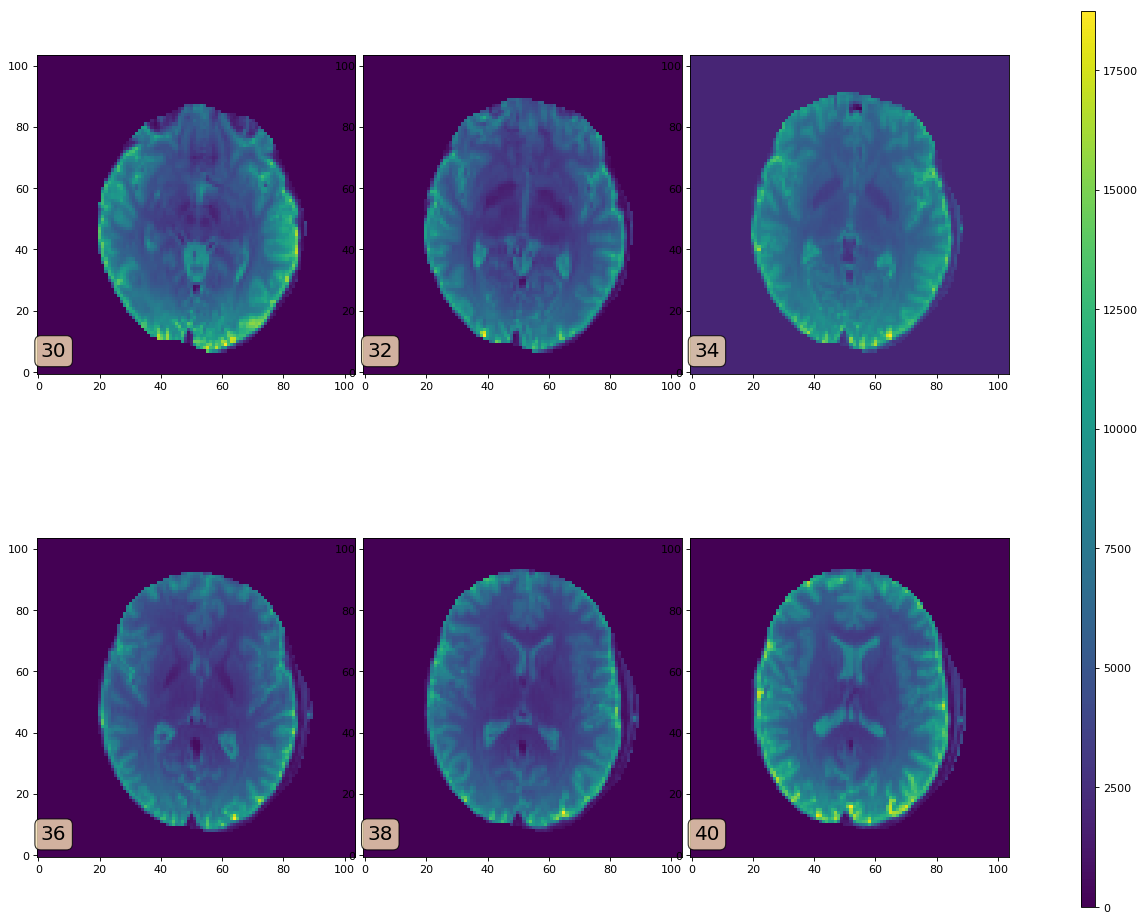

In [8]:
# plot the b0 image for a few z-axis slices
plot_3d_z_indices(maskdata[:,:,:,0], idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)

In [31]:
# take a small region of the original data and make a copy because we are going to modify it
smalldata = maskdata[30:70,30:70,30:41, :].astype(np.float_, copy=True)
smalldata.shape

(40, 40, 11, 183)

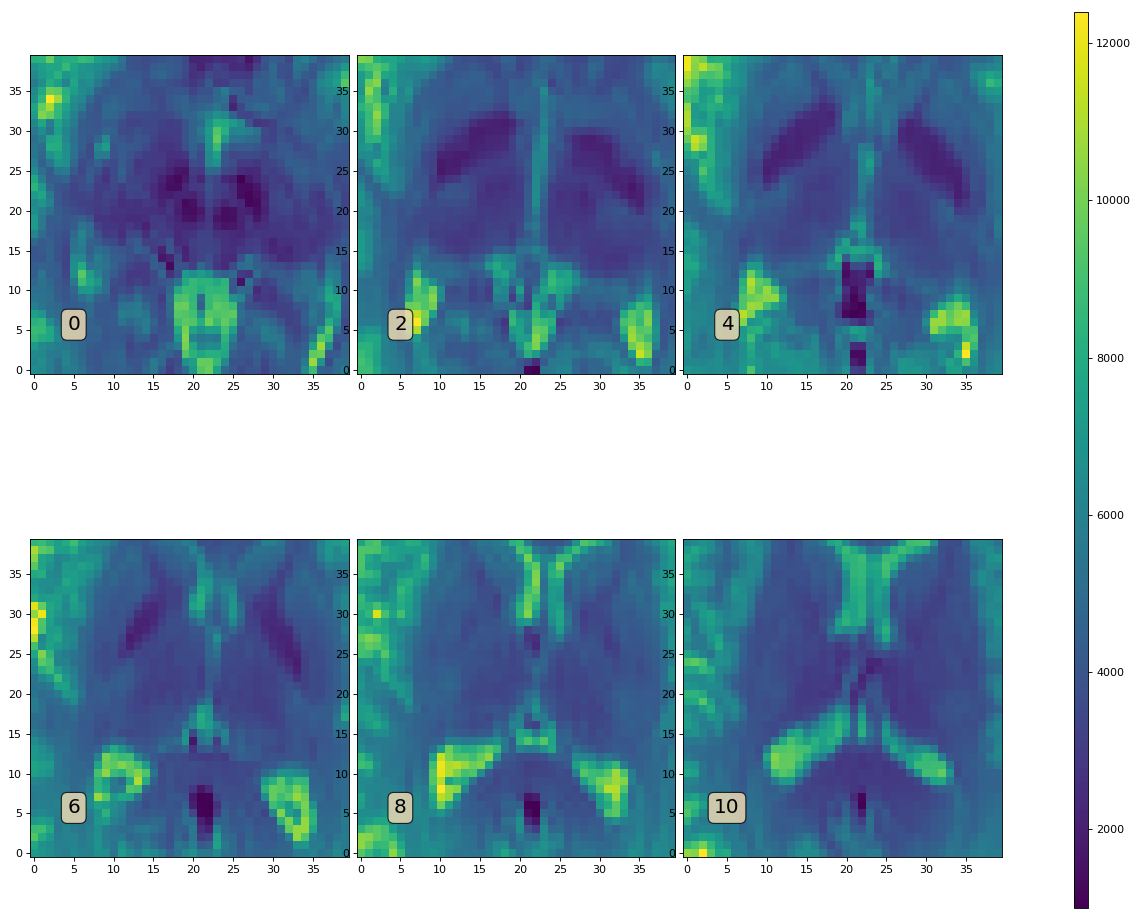

In [32]:
# Plot a few slices of the smaller dataset
plot_3d_z_indices(smalldata[:,:,:,0], idx_list=range(0, 11, 2) , num_rows=2, num_cols=3)

# Now let us work with smalldata and get the freewater maps, FA, corrected-FA etc

In [33]:
smalldata.nbytes / 1e6

25.7664

In [12]:
from freewater import FreeWaterGradientDescent, create_feature_spatial_manifold
from freewater import convert_manifold_to_lower_tri_order
from tracer import LossTracer, IdxTracer

from dipy.reconst.vec_val_sum import vec_val_vect
from dipy.reconst.dti import decompose_tensor, from_lower_triangular
from dipy.reconst.dti import MIN_POSITIVE_SIGNAL
MIN_POSITIVE_EIGENVALUE = 1e-12

def log_transform_to_qform(evals, evecs):
    """Takes evals and evecs and returns a q-form that can be sent into free water calc"""
    evals_copy = evals.copy()
    evals_copy[evals_copy <= 0] = MIN_POSITIVE_EIGENVALUE
    qform = vec_val_vect(evecs, evals)
    return(qform)

def exp_transform_from_qform(qform):
    """Takes a q form and returns evals and evecs"""
    return (decompose_tensor(from_lower_triangular(qform), min_diffusivity=MIN_POSITIVE_EIGENVALUE))

class FreewaterRunner:
    """ This class interfaces with the class FreeWaterGradientDescent which actually 
        runs the gradient descent. Here we
          1. Prepare the data in form required by class FreeWaterGradientDescent
          2. Do the log-euclidean transform
          3. Do the reverse log-euclidean transform to get the data back in the manifold"""
    pass




In [47]:
# make sure that all small signals or zero or negative are replaced 
# by the minimum positive signal
smalldata[smalldata <= MIN_POSITIVE_SIGNAL] = MIN_POSITIVE_SIGNAL

# Let's extract out the b0 part of the data
smalldata_b0 = smalldata[:,:,:, ss_gtab.b0s_mask]

# If we do not have the signal intensity of tissue and Water in the b0 image
# Let us estimate it to be `the upper ends of the distribution
(Stissue, Swater) = np.percentile(smalldata_b0.ravel(), q=[0.1, 99.9])
print("Stissue =", Stissue, ": Swater =", Swater)

# Set the single shell bval to be the first index in the gradient table that is not marked as 
# as a b0 value. All these values should be the same (eg. b=1000) however sometimes we have values
# that are close to 1000 (eg. 995, 1005 etc). We are just picking the first non-zero value and 
# that should be good enough
b_value = ss_gtab.bvals[np.where(~ss_gtab.b0s_mask)[0][0]]
print("Single shell bvalue =", b_value)

Stissue = 719.733457397 : Swater = 10573.4928242
Single shell bvalue = 1000.0


In [56]:
# calculate the signal attenuations
Ahat = smalldata[:,:,:, ~ss_gtab.b0s_mask] / smalldata_b0

MAX_DIFFUSIVITY = 5 * 1e-3

attenuation_min = np.exp(- b_value * MAX_DIFFUSIVITY )

MIN_DIFFUSIVITY = 0.01 * 1e-3
attenuation_max = np.exp(-b_value * MIN_DIFFUSIVITY)

print("Attenuation_min = %.3f, Attenuation_max = %.3f" % 
      (attenuation_min, attenuation_max))

#Clip the attenuations to attenuation_min and attenuation_max
mask = Ahat < attenuation_min
Ahat[Ahat < attenuation_min] = attenuation_min

mask = Ahat > attenuation_max
Ahat[Ahat > attenuation_max] = attenuation_max

print("Ahat.shape =", Ahat.shape)

Attenuation_min = 0.007, Attenuation_max = 0.990
Ahat.shape = (40, 40, 11, 182)
